<a href="https://colab.research.google.com/github/opsifiz/AIB5_Emotion-Classification/blob/main/baseline/baseline_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Download Data Set

In [ ]:
import pandas as pd
import json

In [ ]:
!gdown https://drive.google.com/uc?id=1GCiVfkylV1hSdv6nvG5Wqt9h-8gSNf7i

Downloading...
From (original): https://drive.google.com/uc?id=1GCiVfkylV1hSdv6nvG5Wqt9h-8gSNf7i
From (redirected): https://drive.google.com/uc?id=1GCiVfkylV1hSdv6nvG5Wqt9h-8gSNf7i&confirm=t&uuid=47780464-0b9e-4db7-abb0-7622d84aabb7
To: /content/cleaned_dataset.csv
100% 990M/990M [00:11<00:00, 84.9MB/s]


In [ ]:
df = pd.read_csv('cleaned_dataset.csv',index_col=False)
#Create Temporay Dataset where each status have 100 texts.
temp = df
temp = temp.groupby('status').head(100)
temp = temp.drop(columns=['from'])
temp['predict'] = '-'
df = temp
df = df.reset_index(drop=True)
df

,text,status,predict
0,oh my gosh,Anxiety,-
1,trouble sleeping confused mind restless heart ...,Anxiety,-
2,all wrong back off dear forward doubt stay in ...,Anxiety,-
3,i have shifted my focus to something else but ...,Anxiety,-
4,i am restless and restless it is been a month ...,Anxiety,-
...,...,...,...
995,hey you all so a few years back i was supposed...,schizophrenia,-
996,my friend is too busy dealing with her own men...,schizophrenia,-
997,i feel like everything i have gone through in ...,schizophrenia,-
998,lately i have had this strange feeling like a ...,schizophrenia,-


#Baseline #4

In [10]:
df = df[df['status'] != 'Personality disorder']

In [11]:
df['status'].value_counts().index

Index(['Anxiety', 'Normal', 'depression', 'Suicidal', 'Stress', 'bipolar',
       'BPD', 'schizophrenia', 'mentalillness'],
      dtype='object', name='status')

In [ ]:
from google import genai

client = genai.Client(api_key='GEMINI_API_KEY')

In [14]:
def gemini_classify(txt):
  #BEGIN PROMPT
  prompt = "You are the best therapist, your work is to define this message that what kind of status is in this message:\n\nmessage : \""+txt+"\"\n"
  #END PROMPT
  # print(prompt)
  response = client.models.generate_content(
    model="gemini-2.0-flash-lite",
    contents=prompt,
    config={
        'response_mime_type': 'text/x.enum',
        'response_schema': {
            "type": "STRING",
            "enum":['Anxiety', 'Normal', 'depression', 'Suicidal', 'Stress', 'bipolar', 'BPD', 'schizophrenia', 'mentalillness'],
        },
    },
  )
  return response.text

In [56]:
import time

for i in range(900):
  if(df.iloc[i]['predict'] != '-'):
    continue
  msg = gemini_classify(df.iloc[i]['text'])
  df.at[i, 'predict'] = msg
  print(i,msg)
  if (i+1)%100 == 0:
    df.to_csv('classify_data_'+str((i+1)//100)+'.csv')
  time.sleep(2)

df.to_csv('drive/MyDrive/baseline/baseline4.csv', index=False)

In [49]:
df.describe()

,text,status,predict
count,900,900,900
unique,900,9,9
top,it does not help that it is my trauma month in...,Anxiety,Anxiety
freq,1,100,182


In [50]:
df['predict'].value_counts()

,count
predict,
Anxiety,182
depression,164
Normal,147
Suicidal,113
BPD,106
Stress,92
schizophrenia,45
mentalillness,29
bipolar,22


In [51]:
all_status = df['status'].unique()
all_status

array(['Anxiety', 'Normal', 'depression', 'Suicidal', 'Stress', 'bipolar',
       'BPD', 'schizophrenia', 'mentalillness'], dtype=object)

In [52]:
accuracy = ((df['predict']==df['status']).sum())/1000
print(accuracy)

0.461


<Figure size 800x600 with 0 Axes>

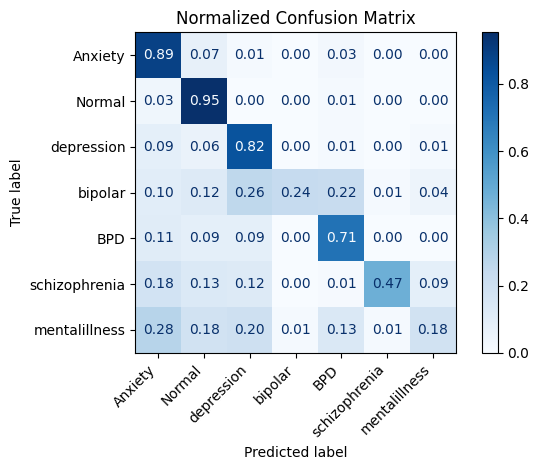

In [54]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

candidate_labels = ['Anxiety', 'Normal', 'depression', 'bipolar', 'BPD', 'schizophrenia', 'mentalillness']
# Compute normalized confusion matrix
cm = confusion_matrix(df['status'], df['predict'], labels=candidate_labels, normalize='true')

# Display normalized confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=candidate_labels)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", values_format=".2f")
plt.xticks(rotation=45, ha='right')
plt.title("Normalized Confusion Matrix")
plt.tight_layout()
plt.show()